In [17]:
# import files needed.
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn import neighbors
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV,cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

Mushroom Data: Poisonous (-1) vs. Edible (1)

In [18]:
mushroom = pd.read_csv("../118Aproject/mushroom.csv")   # Load data from file.

mushroom = pd.get_dummies(mushroom)
encoded_mushroom = mushroom.to_numpy().astype(np.float) # Convert df to np array.
X_shroom = encoded_mushroom[:, 2:len(encoded_mushroom)] # Third column to last column: Features. 
Y_shroom = encoded_mushroom[:,0]                        # First column: Labels.
Y_shroom[Y_shroom==0] = -1                              # Convert labels from {0, 1} to {-1, 1}.
Y_shroom = np.reshape(Y_shroom, (8123,-1))
shroom = np.hstack((X_shroom, Y_shroom))                # Stack them together for shuffling.
                   
print(X_shroom.shape)                                   # (8123, 117)
print(Y_shroom.shape)                                   # (8123,1)

(8123, 117)
(8123, 1)


Getting Iris Data: Setosa/Versicolor (-1) vs. Virginica (1)

In [19]:
iris = pd.read_csv("../118Aproject/iris.csv")               # Load data from file.

le = LabelEncoder()                                         # Encode Iris Types.
le.fit(iris['G'])
iris['G'] = le.transform(iris['G'])
encoded_iris = iris.to_numpy().astype(np.float)             # Convert df to np array.
X_iris = encoded_iris[:, 1:-1]  
Y_iris = (encoded_iris[:,-1] > 1.5).reshape(-1,1).astype(np.float)
Y_iris[Y_iris==0] = -1 
iris = np.hstack((X_iris, Y_iris))                          # Stack 

print(X_iris.shape)                                         # (150, 4)
print(Y_iris.shape)                                         # (150,1)

(150, 4)
(150, 1)


Getting Wine Data: Low Quality (-1) vs. High Quality (1)

In [20]:
wine = pd.read_csv("../118Aproject/wine.csv")  # Load data from file

wine_array = wine.to_numpy().astype(np.float)  # Convert df to np array.
X_wine = wine_array[:, 1:-1] 
Y_wine = (wine_array[:,-1] > 6.5).reshape(-1,1).astype(np.float)
Y_wine[Y_wine==0] = -1 
wine = np.hstack((X_wine, Y_wine))             # Stack

print(X_wine.shape)                            # (1599, 10)
print(Y_wine.shape)                            # (1599,1)

(1599, 10)
(1599, 1)


Getting Income Data: <=50k (-1) vs. >50k (1)

In [21]:
income = pd.read_csv("../118Aproject/adult.csv")  # Load data from file.

In [22]:
income2 = income.replace({' ?': np.nan})
income2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         30725 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital.gain      32561 non-null int64
capital.loss      32560 non-null float64
hours.per.week    32561 non-null int64
native.country    31978 non-null object
income            32561 non-null object
dtypes: float64(1), int64(5), object(9)
memory usage: 3.7+ MB


In [23]:
# clean data.
income2.drop(labels=["workclass","education","relationship","race","native.country","occupation"], axis = 1, inplace = True)
income2['capital.loss'].fillna(income2['capital.loss'].mode()[0], inplace=True)

le = LabelEncoder()                                 
le.fit(income2['marital.status'])                  # marital status encode.
income2['marital.status'] = le.transform(income2['marital.status'])
income2 = income2.replace(to_replace =[" Male","<=50K"],  
                            value = 0)
income2 = income2.replace(to_replace =[" Female",">50K"],  
                            value = 1)

income_array = income2.to_numpy().astype(np.float) # Convert df to np array.
X_income = income_array[:, 0:-1] 
Y_income = income_array[:,-1]
Y_income = np.reshape(Y_income, (32561,-1))
income = np.hstack((X_income, Y_income))           # Stack t
 

print(X_income.shape)                              # (32561, 8)
print(Y_income.shape)                              # (32561,1)

(32561, 8)
(32561, 1)


Trials

In [24]:
datasets = [iris,shroom,wine,income]
partitions = [.8, .5, .2]

# Params for Random Forest cv
max_feature_total = [1, 2, 4, 6, 8, 12, 16, 20] 
max_depth = [1, 2, 3, 4, 5] 

# Params for Logistic Regression cv
C_range = [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000] 

# Params for KNN cv
K_list = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]) 

# Params for Decision Tree cv
D_list = [1, 2, 3, 4, 5]

models = []
models.append(('RF', RandomForestClassifier(n_estimators=1024)))
models.append(('LOGREG', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier(metric='euclidean')))
models.append(('DT', DecisionTreeClassifier(criterion='entropy')))

In [25]:
# fit number for each dataset.
def num_features(dataset):
    num = dataset.shape[1]
    feature_size = []
    for i in range(len(max_feature_total)):
        if num >= max_feature_total[i]:
            feature_size.append(max_feature_total[i])
    return feature_size

In [26]:
# Accuracy calculations between features and result.
def calc_accuracy(X, Y, classifier):
    Y_pred = classifier.predict(X)
    a = accuracy_score(Y, Y_pred)
    return a

In [27]:
# Draw heatmaps for result of grid search.
def draw_heatmap(errors, D_list, title):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
    ax.collections[0].colorbar.set_label('accuracy')
    ax.set(ylabel='hyperparam')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title(title)
    plt.show()

In [72]:
# Main Algorithm for computing.
results = []
max_features= []
heatmap = True
arr = []
data = pd.DataFrame(columns=["train", "val", "test"])

for dataset in datasets:
    max_features = num_features(dataset)
    for split in partitions:
        print("split ",split)
        for trial in range(3):
            testing_acc = []
            training_acc = []
            cross_val_acc = []
            
            np.random.shuffle(dataset)      # shuffle 
            X = dataset[:, 0:-1]            # First column to second last column: Features. 
            Y = dataset[:, -1]              # Last column: Labels.

            X_shuffled = X
            Y_shuffled = Y    
        
            X_train, X_test, Y_train, Y_test = train_test_split(X_shuffled,Y_shuffled,
            test_size=split)               # split
            
            params = {
                models[0][0]:{'max_depth':max_features, 'max_depth':max_depth}, #RF
                models[1][0]:{'C':C_range},                                     #LOGREG
                models[2][0]:{'n_neighbors':K_list},                            #KNN
                models[3][0]:{'max_depth':D_list}                               #DT
            }
            
            for name, model in models:
                print(name)
                # cross validate
                grid_search = GridSearchCV(model, params[name], cv=5)
                # train
                grid_search.fit(X_train, Y_train)
                # optimal hyperparameters
                best_params = grid_search.best_params_
                classifier = grid_search.best_estimator_
                # training and validation error
                mean_train = calc_accuracy(X_train, Y_train, classifier)
                training_acc.append(mean_train)
                mean_val = np.average(grid_search.cv_results_['mean_test_score'])
                cross_val_acc.append(mean_val)
                # test and testing accuracy
                mean_test = calc_accuracy(X_test, Y_test, classifier)
                testing_acc.append(mean_test)
                
                print(str(round(mean_train,2)))
                print(mean_val)
                print(str(round(mean_test,2)))
                arr.append(np.array([round(mean_train,2),round(mean_val,2),round(mean_test,2)]))
                # heatmaps for one trial
                if heatmap == True:
                    results.append(grid_search.cv_results_['mean_test_score'])     
            heatmap = False
            print("per trial test accuracy: ", round(np.average(testing_acc),2)) 
            
        print("train, validation, test accuracies.")
        print(round(np.average(cross_val_acc),2))
        print(round(np.average(testing_acc),2))
        print(round(np.average(training_acc),2))
        print('\n')



split  0.8
RF
1.0
0.9
0.93
LOGREG
0.97
0.8564102564102565
0.93
KNN
0.93
0.8144927536231886
0.91
DT
1.0
0.9133333333333334
0.93
per trial test accuracy:  0.93
RF
1.0
0.9333333333333333
0.94
LOGREG
0.97
0.7846153846153847
0.97
KNN
0.97
0.8405797101449278
0.86
DT
0.97
0.9066666666666666
0.94
per trial test accuracy:  0.93
RF
1.0
0.9666666666666666
0.95
LOGREG
0.97
0.7794871794871795
0.97
KNN
0.87
0.7753623188405797
0.96
DT
1.0
1.0
0.95
per trial test accuracy:  0.96
train, validation, test accuracies.
0.88
0.96
0.96


split  0.5
RF
0.97
0.944
0.95
LOGREG
0.97
0.7969230769230771
0.97
KNN
0.97
0.9484057971014489
0.97
DT
0.96
0.9280000000000002
0.95
per trial test accuracy:  0.96
RF
0.97
0.96
0.92
LOGREG
0.97
0.8071794871794871
0.96
KNN
0.97
0.9362318840579711
0.95
DT
0.99
0.9600000000000002
0.93
per trial test accuracy:  0.94
RF
0.97
0.9733333333333334
0.96
LOGREG
1.0
0.8082051282051282
0.93
KNN
1.0
0.9594202898550721
0.96
DT
1.0
0.9626666666666667
0.95
per trial test accuracy:  0.95
train,

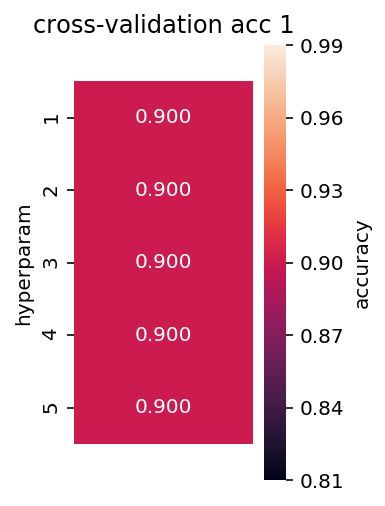

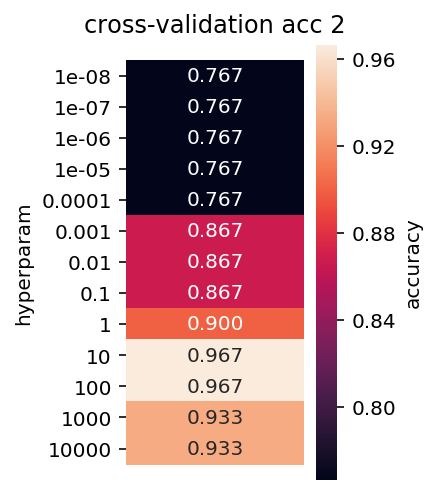

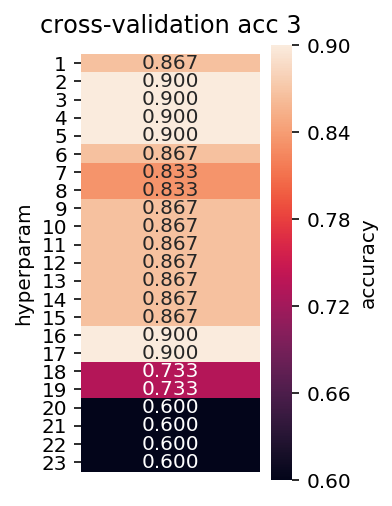

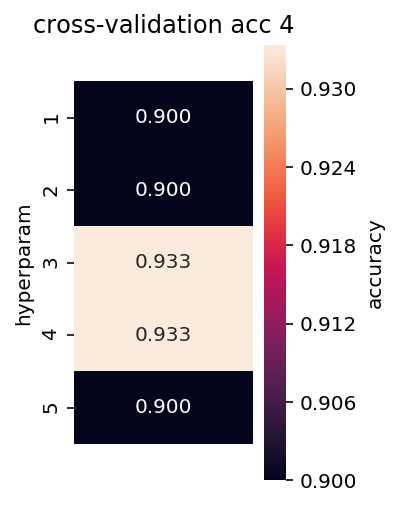

In [73]:
draw_heatmap(results[0].reshape(5,1), max_depth, title='cross-validation acc 1')
draw_heatmap(results[1].reshape(13,1), C_range, title='cross-validation acc 2')
draw_heatmap(results[2].reshape(23,1), K_list , title='cross-validation acc 3')
draw_heatmap(results[3].reshape(5,1), D_list, title='cross-validation acc 4')

In [76]:
data = pd.DataFrame(arr,columns=["train", "val", "test"])      
data.to_csv('data.csv')